In [1]:
import pandas as pd
import numpy as np
import warnings
from scipy import stats
from IPython.display import display, HTML
from sklearn import metrics as me
from sklearn.preprocessing import label_binarize
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows",20)
pd.set_option('precision', 4)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import OneHotEncoder
from itertools import cycle
from matplotlib import cm

%pdb
%matplotlib inline

Automatic pdb calling has been turned ON


In [2]:
matplotlib.style.use('seaborn-notebook')
print(plt.style.available)
matplotlib.rcParams['font.family'] = "Times New Roman"


['seaborn-dark', 'seaborn-poster', 'grayscale', 'seaborn-muted', 'seaborn-paper', 'seaborn-bright', 'dark_background', 'seaborn-whitegrid', 'seaborn-white', 'seaborn-colorblind', 'seaborn-ticks', 'seaborn-notebook', 'seaborn-pastel', 'fivethirtyeight', 'seaborn', 'seaborn-darkgrid', 'seaborn-deep', 'classic', '_classic_test', 'bmh', 'seaborn-talk', 'ggplot', 'seaborn-dark-palette']


In [3]:


import itertools
#matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          append = "",
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Confusion matrix {}'.format(append)
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive "],
             ["\n False Negative ", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value, scenario):
    from sklearn.metrics import confusion_matrix
    append = '{}; \n Total Normal traffic:{}, \n Total Attack Traffic: {}'.format(scenario, 
                                                                            actual_value.groupby(actual_value).count()[0], 
                                                                           actual_value.groupby(actual_value).count()[1])
    
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False, append = append)


In [4]:
def evaluate_lstm(model, past_scores, predictions):
    return evaluate(model, past_scores, predictions, 'LSTM')

lstm_result = []

def display_and_save(name, plot):
    fig = plot.get_figure()
    #fig.savefig("result_plots/{}.eps".format(name.replace(":","").strip()), format='eps', dpi=1000)
    #fig.savefig("result_plots/{}.png".format(name.replace(":","").strip()), format='png', dpi=1000)
    display(plot)

def evaluate(model, past_scores, predictions, model_type='AE'):
    all_scenarios = pd.DataFrame(columns=['Model','Scenarios', 'Number of Features', 'Accuracy', 'Quality Score', 'Precision', 'Recall'])

    
    def get_best_df(past_scores):
        psg = past_scores.sort_values(by='quality_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.first().sort_values(by='quality_score', ascending=False)
        #df = past_scores.sort_values(by='key')#[past_scores.key == '20151201']

        return df
    def get_median_df(past_scores):
        psg = past_scores.sort_values(by='quality_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.nth(int(psg.size()[0]/2)).sort_values(by='quality_score', ascending=False)
        return df
    def get_worst_df(past_scores):
        psg = past_scores.sort_values(by='quality_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.last().sort_values(by='quality_score', ascending=False)
        return df
    
    def get_result(past_scores, which='best'):
        if which == 'best':
            df = get_best_df(past_scores)
        elif which == 'median':
            df = get_median_df(past_scores)
        elif which == 'worst':
            df = get_worst_df(past_scores)
            
        #epoch_nof_hidden
        key = int(df.iloc[0]['key'])
        nof = df.iloc[0].name[0]
        hidden = df.iloc[0].name[1]
        
        return "{}_{}_{}".format(key, nof, hidden), nof, df

    def view_data(name, past_scores, which):
        _, _, df = get_result(past_scores, which)
        display(name)
        display(df)
        
        group_by = 'no_of_features'
        if(model_type == 'LSTM'):
            group_by = 'hidden_layers'
        df1 = df.reset_index().sort_values(by='quality_score', ascending=False).groupby(by=[group_by])
        
        df1 = df1.first().loc[:,['quality_score', 'time_taken']]
        df1 = df1.rename(index={1:"One", 4:"10%", 8:"20%", 16:"40%", 42:"All"})
        plot = df1.plot(secondary_y = 'time_taken', title=name)#,figsize=(10, 10))
        display_and_save(name, plot)
        
    #display("Individual Results for each Scenario:-")    
    view_data("   Results for {}: Best case".format(model),past_scores, 'best')
    view_data("   Results for {}: General case".format(model),past_scores,'median')
    view_data("   Results for {}: Worst case".format(model),past_scores,'worst')
        
    def get_score(y_true, y_pred):
        f1 = me.matthews_corrcoef(y_true, y_pred)
        pre = me.precision_score(y_true, y_pred)
        rec = me.recall_score(y_true, y_pred)
        acc = me.accuracy_score(y_true, y_pred)
        #plot_auc(y_true, y_pred)
        return {"Quality Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}
    
    display("Combined Results from all Scenarios for {}".format(model))

    def plot_auc(y_true, y_pred):
        y_true = y_true.astype(type(""))
        y_pred = y_pred.astype(type(""))
        
        y_true_oh = pd.get_dummies(y_true).values
        y_pred_oh = pd.get_dummies(y_pred.astype('category', categories = [0,1])).values
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in [0,1]:
            fpr[i], tpr[i], _ = me.roc_curve(y_true_oh[:,i], y_pred_oh[:,i])
            roc_auc[i] = me.auc(fpr[i], tpr[i])
        fpr["micro"], tpr["micro"], _ = me.roc_curve(y_true_oh.ravel(), y_pred_oh.ravel())
        roc_auc["micro"] = me.auc(fpr["micro"], tpr["micro"])
        plt.figure()
        lw = 2
        colors = cycle(['aqua', 'cornflowerblue'])
        for i, color in zip([0,1], colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve for {0} (area = {1:0.2f})'
                     ''.format("Normal" if i == 0 else "Attack", roc_auc[i]))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-AUC Curve for {}'.format(model))
        plt.legend(loc="lower right")
        display(plt.show())
        
    def accumulate_scenarios(predictions, past_scores, which='best'):
        key, nof, df = get_result(past_scores, which)
        y_true = predictions[key]["Actual"]
        y_pred = predictions[key]["Prediction"]
        y_true = y_true.dropna()
        y_pred = y_pred.dropna()
        
        scores = get_score(y_true, y_pred)
        scores.update({"Scenarios":scenario,"Number of Features":nof,"Model":model, "Duration(secs)": df.iloc[0]['time_taken']})
        plot(y_true, y_pred, "{}_{}".format(scenario, key))
        return pd.DataFrame(scores, index=[1])
    
    scenario = "Best Result"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, 'best'))
    scenario = "Average Result"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, 'median'))
    scenario = "Worst Result"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, 'worst'))
    
    
    display(all_scenarios.set_index(['Model','Scenarios','Number of Features']))

    return all_scenarios
    
    
    
    
    

In [5]:
past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")
predictions = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")


'   Results for FCN: Best case'

key  train_score  test_score  \
no_of_features hidden_layers                                      
1              3              20151203       0.7110      0.9032   
4              1              20151203       0.3289      0.5130   
1              1              20151226       0.3210      0.5000   
4              3              20151224       0.3360      0.5000   
8              3              20151230       0.3202      0.5000   
16             1              20151221       0.3213      0.5000   
               3              20151217       0.4357      0.5000   
42             1              20151230       0.3247      0.5000   
               3              20151212       0.3200      0.5000   
8              1              20151204       0.3277      0.4996   

                              quality_score  time_taken  
no_of_features hidden_layers                             
1              3                     0.5448     55.0450  
4              1                     0.1427     50.3318  
1              1                     0.0000     55.3797  
4              3                     0.0000     57.8753  
8              3                     0.0000     58.0009  
16             1                     0.0000     51.4747  
               3                     0.0000     60.3034  
42             1                     0.0000     52.1108  
               3                     0.0000     67.9701  
8              1                    -0.0019     50.2288

'   Results for FCN: General case'

key  quality_score  test_score  time_taken  \
no_of_features hidden_layers                                                    
1              3              20151217         0.1945      0.7495     55.0450   
               1              20151230         0.0000      0.5000     55.3797   
4              3              20151203         0.0000      0.5000     57.8753   
8              3              20151205         0.0000      0.5000     58.0009   
16             1              20151204         0.0000      0.5000     51.4747   
               3              20151220         0.0000      0.5000     60.3034   
42             1              20151220         0.0000      0.5000     52.1108   
               3              20151223         0.0000      0.5000     67.9701   
4              1              20151226        -0.0011      0.5000     50.3318   
8              1              20151214        -0.0085      0.4976     50.2288   

                              train_score  
no_of_features hidden_layers               
1              3                   0.7110  
               1                   0.3210  
4              3                   0.3360  
8              3                   0.3202  
16             1                   0.3213  
               3                   0.4357  
42             1                   0.3247  
               3                   0.3200  
4              1                   0.3289  
8              1                   0.3277

'   Results for FCN: Worst case'

key  train_score  test_score  \
no_of_features hidden_layers                                      
1              3              20151213       0.7110      0.5594   
4              3              20151208       0.3360      0.5000   
8              3              20151225       0.3202      0.5000   
16             1              20151227       0.3213      0.5000   
42             3              20151230       0.3200      0.5000   
               1              20151201       0.3247      0.5000   
1              1              20151219       0.3210      0.5000   
16             3              20151223       0.4357      0.4999   
4              1              20151230       0.3289      0.4995   
8              1              20151219       0.3277      0.4981   

                              quality_score  time_taken  
no_of_features hidden_layers                             
1              3                     0.0246     55.0450  
4              3                     0.0000     57.8753  
8              3                     0.0000     58.0009  
16             1                     0.0000     51.4747  
42             3                     0.0000     67.9701  
               1                    -0.0011     52.1108  
1              1                    -0.0014     55.3797  
16             3                    -0.0029     60.3034  
4              1                    -0.0070     50.3318  
8              1                    -0.0345     50.2288

'Combined Results from all Scenarios for FCN'

Accuracy  Duration(secs)  Precision  \
Model Scenarios      Number of Features                                        
FCN   Best Result    1                     0.8424          55.045     0.9973   
      Average Result 1                     0.7098          55.045     0.9899   
      Worst Result   1                     0.6815          55.045     0.9922   

                                         Quality Score  Recall  
Model Scenarios      Number of Features                         
FCN   Best Result    1                          0.5448  0.8284  
      Average Result 1                          0.1945  0.7069  
      Worst Result   1                          0.0246  0.6838

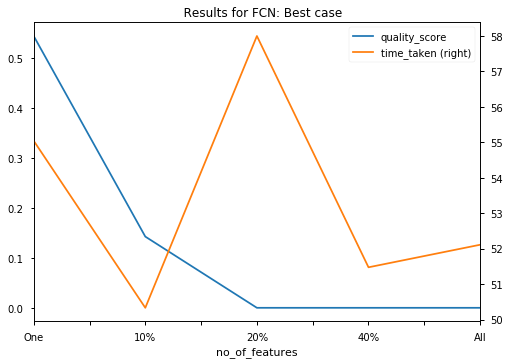

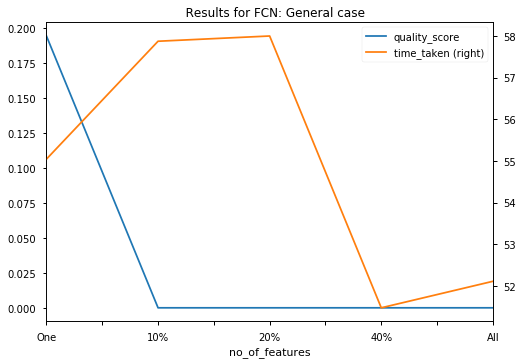

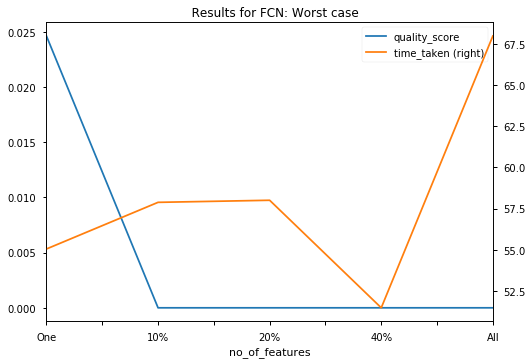

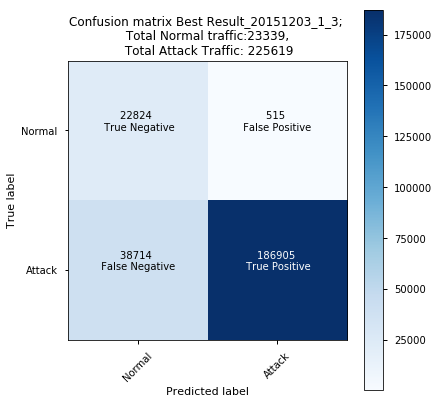

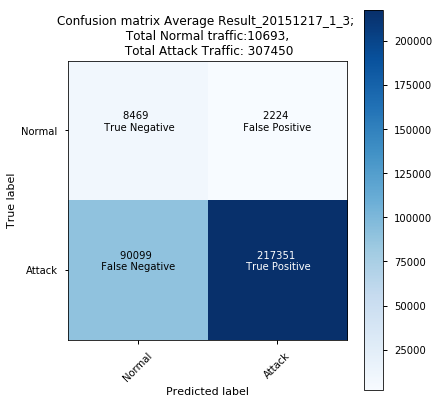

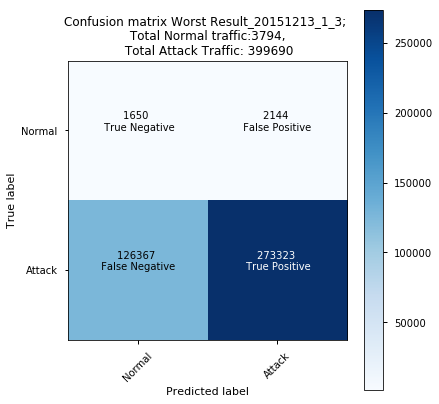

In [6]:
all_scenarios_fcn = evaluate("FCN", past_scores, predictions)

psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
df = psg.first().sort_values(by='f1_score', ascending=False).head(5)
df1 = df.reset_index().sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features'])
df1 = df1.first().loc[:,['f1_score', 'time_taken']]
df1 = df1.rename(index={1:"One", 4:"10%", 8:"20%", 16:"40%", 42:"All"})
df1.plot(secondary_y = 'time_taken', table=True)

In [7]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_scores-all.pkl")
predictions = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")

'   Results for VAE-Softmax: Best case'

,,key,train_score,test_score,quality_score,time_taken
no_of_features,hidden_layers,,,,,
4,3,20151219,0.8921,0.6424,0.3779,45.4121
16,3,20151219,0.9712,0.5809,0.3014,46.3470
8,3,20151219,0.9515,0.5511,0.2021,47.6848
1,3,20151219,0.9405,0.5349,0.1535,43.3863
42,3,20151219,0.9894,0.5196,0.1226,53.2145
1,1,20151224,0.0043,0.5000,0.0000,44.0185
4,1,20151230,0.0029,0.5000,0.0000,35.3700
8,1,20151230,0.0039,0.5000,0.0000,34.6213
16,1,20151204,0.0038,0.5000,0.0000,33.9971


'   Results for VAE-Softmax: General case'

key  quality_score  test_score  time_taken  \
no_of_features hidden_layers                                                    
4              3              20151206         0.0904      0.6175     45.4121   
16             3              20151216         0.0592      0.5433     46.3470   
8              3              20151231         0.0464      0.5177     47.6848   
42             3              20151223         0.0212      0.5060     53.2145   
1              3              20151221         0.0177      0.5144     43.3863   
               1              20151230         0.0000      0.5000     44.0185   
4              1              20151229         0.0000      0.5000     35.3700   
8              1              20151206         0.0000      0.5000     34.6213   
16             1              20151218         0.0000      0.5000     33.9971   
42             1              20151213         0.0000      0.5000     37.0396   

                              train_score  
no_of_features hidden_layers               
4              3                   0.8921  
16             3                   0.9712  
8              3                   0.9515  
42             3                   0.9894  
1              3                   0.9405  
               1                   0.0043  
4              1                   0.0029  
8              1                   0.0039  
16             1                   0.0038  
42             1                   0.0040

'   Results for VAE-Softmax: Worst case'

,,key,train_score,test_score,quality_score,time_taken
no_of_features,hidden_layers,,,,,
42,3,20151221,0.9894,0.5010,0.0020,53.2145
1,1,20151224,0.0043,0.5000,0.0000,44.0185
4,1,20151210,0.0029,0.5000,0.0000,35.3700
8,1,20151224,0.0039,0.5000,0.0000,34.6213
16,1,20151211,0.0038,0.5000,0.0000,33.9971
42,1,20151231,0.0040,0.5000,0.0000,37.0396
1,3,20151211,0.9405,0.4973,-0.0025,43.3863
8,3,20151213,0.9515,0.4929,-0.0048,47.6848
4,3,20151213,0.8921,0.4896,-0.0054,45.4121


'Combined Results from all Scenarios for VAE-Softmax'

Accuracy  Duration(secs)  \
Model       Scenarios      Number of Features                             
VAE-Softmax Best Result    4                     0.7574         45.4121   
            Average Result 4                     0.8853         45.4121   
            Worst Result   42                    0.9723         53.2145   

                                               Precision  Quality Score  \
Model       Scenarios      Number of Features                             
VAE-Softmax Best Result    4                      0.7600         0.3779   
            Average Result 4                      0.9891         0.0904   
            Worst Result   42                     0.9867         0.0020   

                                               Recall  
Model       Scenarios      Number of Features          
VAE-Softmax Best Result    4                   0.9468  
            Average Result 4                   0.8934  
            Worst Result   42                  0.9851

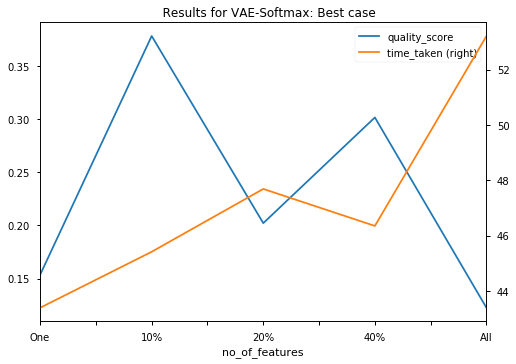

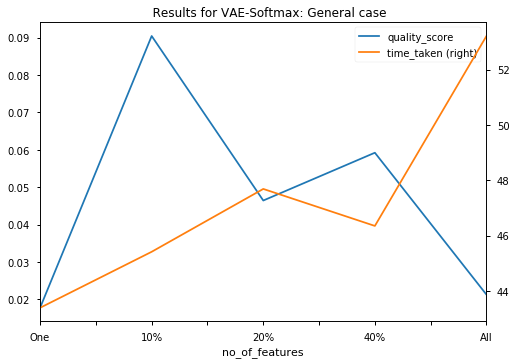

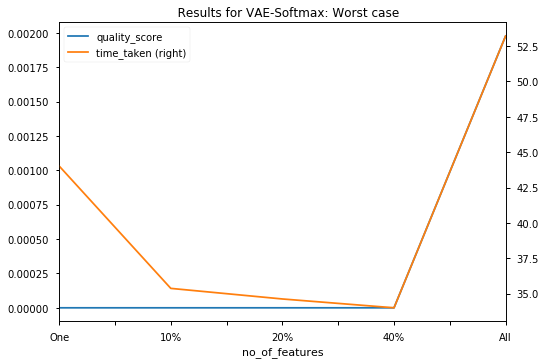

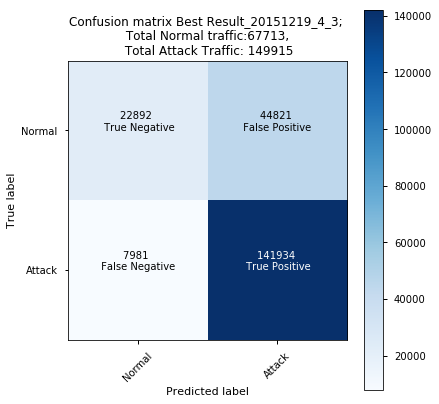

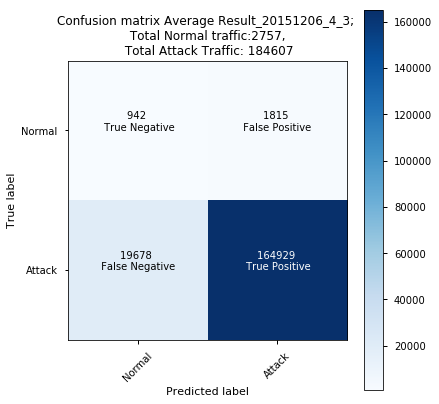

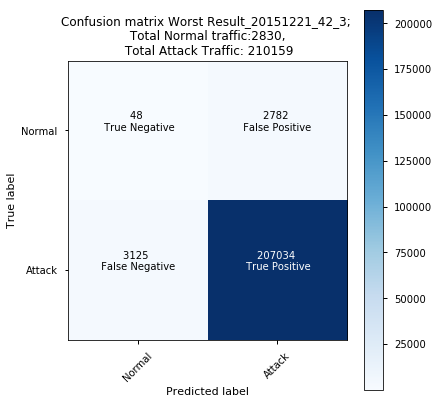

In [8]:
all_scenarios_vae_sm = evaluate("VAE-Softmax", past_scores, predictions)

In [9]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl")
predictions = pd.read_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl")

'   Results for VAE-Label: Best case'

,,key,train_score,test_score,quality_score,time_taken
no_of_features,hidden_layers,,,,,
1,1,20151201,0.7519,0.5712,0.0564,27.1311
8,1,20151226,0.5339,0.5261,0.0313,23.1175
4,3,20151203,0.9878,0.5047,0.0289,30.9148
8,3,20151219,0.9795,0.5029,0.0219,33.2171
16,3,20151231,0.7546,0.5139,0.0171,32.8964
42,3,20151209,0.9930,0.5014,0.0056,34.9470
1,3,20151219,0.9958,0.5000,0.0000,30.7384
4,1,20151225,0.0037,0.5000,0.0000,22.7958
16,1,20151230,0.0035,0.5000,0.0000,23.3167


'   Results for VAE-Label: General case'

key  quality_score  test_score  time_taken  \
no_of_features hidden_layers                                                    
8              1              20151224         0.0057      0.5109     23.1175   
               3              20151215         0.0050      0.5023     33.2171   
4              3              20151224         0.0012      0.5004     30.9148   
1              3              20151221         0.0000      0.5000     30.7384   
4              1              20151228         0.0000      0.5000     22.7958   
16             1              20151211         0.0000      0.5000     23.3167   
42             1              20151227         0.0000      0.5000     28.7404   
               3              20151226        -0.0004      0.5000     34.9470   
16             3              20151210        -0.0061      0.4884     32.8964   
1              1              20151227        -0.0131      0.4726     27.1311   

                              train_score  
no_of_features hidden_layers               
8              1                   0.5339  
               3                   0.9795  
4              3                   0.9878  
1              3                   0.9958  
4              1                   0.0037  
16             1                   0.0035  
42             1                   0.0037  
               3                   0.9930  
16             3                   0.7546  
1              1                   0.7519

'   Results for VAE-Label: Worst case'

,,key,train_score,test_score,quality_score,time_taken
no_of_features,hidden_layers,,,,,
1,3,20151208,0.9958,0.5000,0.0000,30.7384
4,1,20151201,0.0037,0.5000,0.0000,22.7958
16,1,20151228,0.0035,0.5000,0.0000,23.3167
42,1,20151230,0.0037,0.5000,0.0000,28.7404
8,3,20151206,0.9795,0.4992,-0.0015,33.2171
42,3,20151206,0.9930,0.4984,-0.0060,34.9470
4,3,20151218,0.9878,0.4980,-0.0061,30.9148
16,3,20151203,0.7546,0.4715,-0.0391,32.8964
1,1,20151226,0.7519,0.4466,-0.0675,27.1311


'Combined Results from all Scenarios for VAE-Label'

Accuracy  Duration(secs)  \
Model     Scenarios      Number of Features                             
VAE-Label Best Result    1                     0.7419         27.1311   
          Average Result 8                     0.5578         23.1175   
          Worst Result   1                     0.9834         30.7384   

                                             Precision  Quality Score  Recall  
Model     Scenarios      Number of Features                                    
VAE-Label Best Result    1                      0.9752         0.0564  0.7530  
          Average Result 8                      0.9835         0.0057  0.5595  
          Worst Result   1                      0.9834         0.0000  1.0000

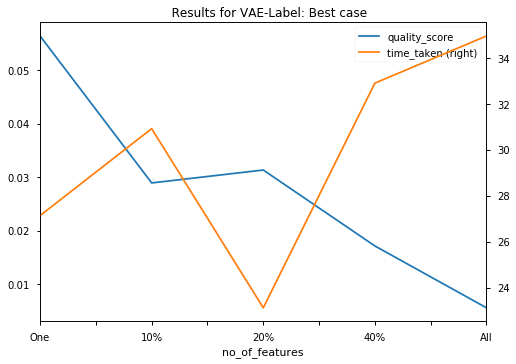

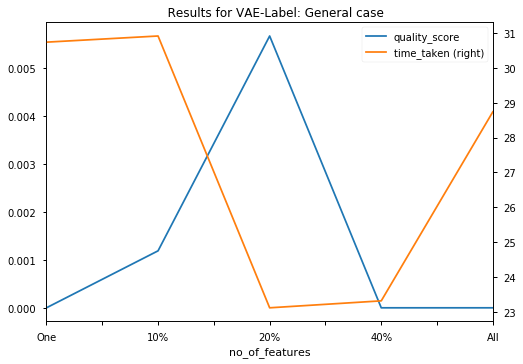

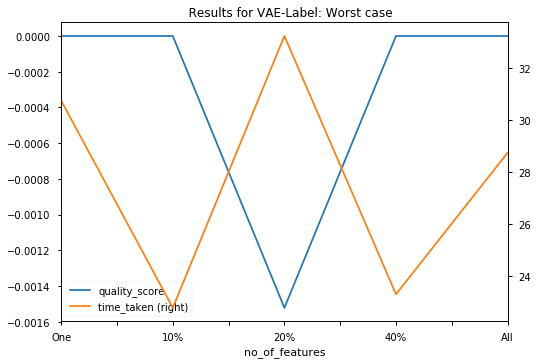

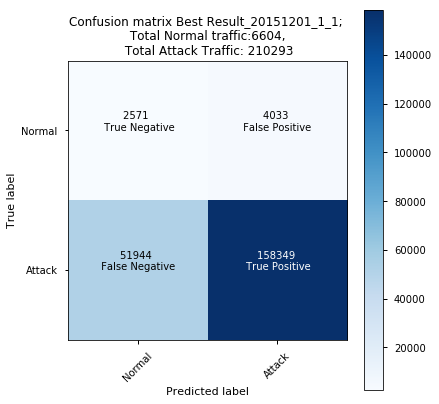

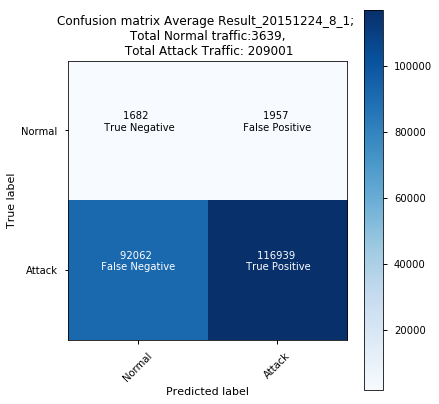

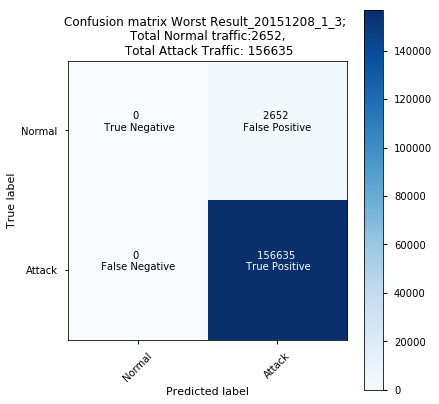

In [10]:
all_scenarios_vae = evaluate("VAE-Label", past_scores, predictions)

In [11]:
past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl")
predictions = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions.pkl")

'   Results for LSTM-Seq2Seq: Best case'

key  train_score  test_score  \
no_of_features hidden_layers                                      
1              3              20151230       1.0000      1.0000   
               1              20151214       0.9997      0.8542   

                              quality_score  time_taken  
no_of_features hidden_layers                             
1              3                     1.0000      9.2020  
               1                     0.8391      6.2228

'   Results for LSTM-Seq2Seq: General case'

key  quality_score  test_score  time_taken  \
no_of_features hidden_layers                                                    
1              3              20151209         1.0000      1.0000      9.2020   
               1              20151220         0.4407      0.6904      6.2228   

                              train_score  
no_of_features hidden_layers               
1              3                   1.0000  
               1                   0.9997

'   Results for LSTM-Seq2Seq: Worst case'

key  train_score  test_score  \
no_of_features hidden_layers                                      
1              3              20151214       1.0000      1.0000   
               1              20151221       0.9997      0.6223   

                              quality_score  time_taken  
no_of_features hidden_layers                             
1              3                     0.9975      9.2020  
               1                     0.1022      6.2228

'Combined Results from all Scenarios for LSTM-Seq2Seq'

Accuracy  Duration(secs)  \
Model        Scenarios      Number of Features                             
LSTM-Seq2Seq Best Result    1                        1.0           9.202   
             Average Result 1                        1.0           9.202   
             Worst Result   1                        1.0           9.202   

                                                Precision  Quality Score  \
Model        Scenarios      Number of Features                             
LSTM-Seq2Seq Best Result    1                         1.0            1.0   
             Average Result 1                         1.0            1.0   
             Worst Result   1                         1.0            1.0   

                                                Recall  
Model        Scenarios      Number of Features          
LSTM-Seq2Seq Best Result    1                      1.0  
             Average Result 1                      1.0  
             Worst Result   1                      1.0

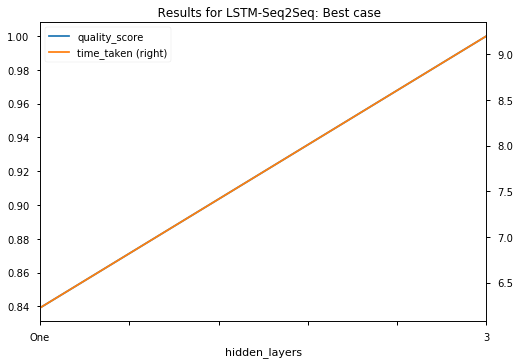

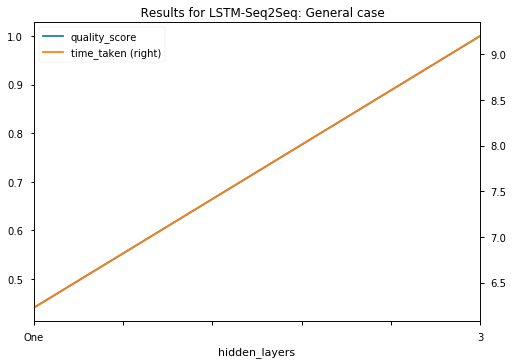

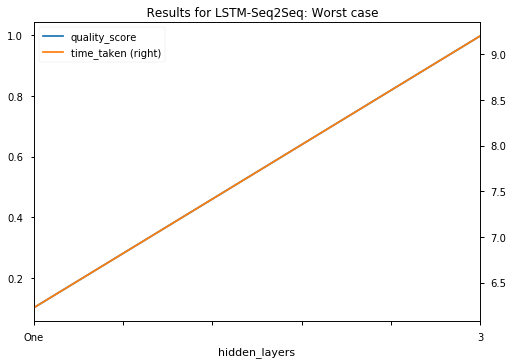

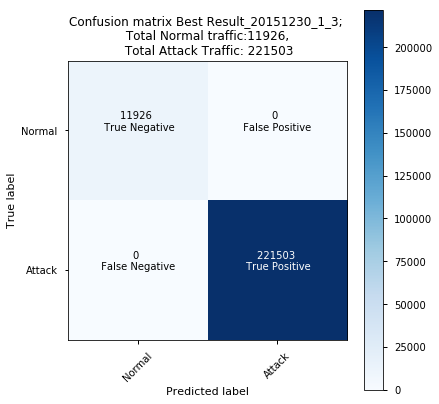

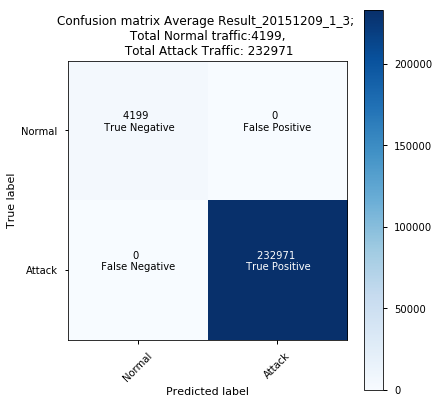

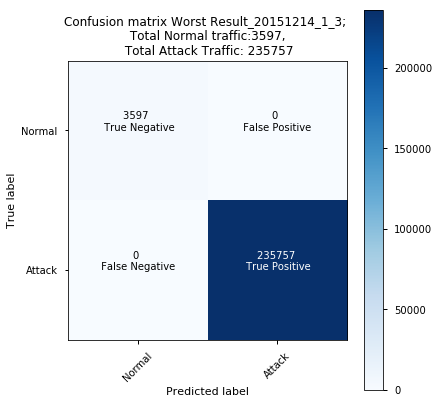

In [12]:
all_scenarios_lstm = evaluate_lstm("LSTM-Seq2Seq", past_scores, predictions)

In [13]:
all_scenarios = pd.concat([all_scenarios_fcn, all_scenarios_vae, all_scenarios_vae_sm,  all_scenarios_lstm],axis=0)

In [14]:
all_scenarios_display = all_scenarios.set_index(['Model', 'Scenarios', 'Number of Features'])
#all_scenarios_display

In [15]:
all_scenarios_best = all_scenarios.set_index(['Scenarios', 'Model']) #, 'Number of Features'
all_scenarios_best.loc['Best Result']


,Accuracy,Duration(secs),Number of Features,Precision,Quality Score,Recall
Model,,,,,,
FCN,0.8424,55.0450,1,0.9973,0.5448,0.8284
VAE-Label,0.7419,27.1311,1,0.9752,0.0564,0.7530
VAE-Softmax,0.7574,45.4121,4,0.7600,0.3779,0.9468
LSTM-Seq2Seq,1.0000,9.2020,1,1.0000,1.0000,1.0000


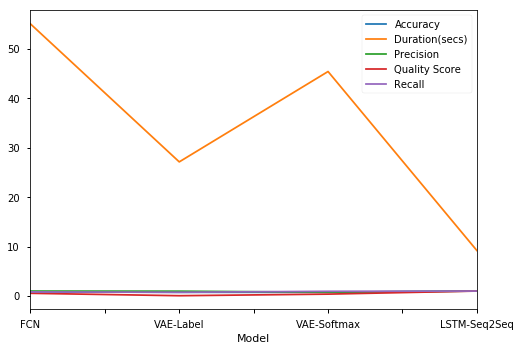

In [16]:
plot = all_scenarios_best.loc['Best Result'].drop('Number of Features', axis = 1).plot()
display_and_save("all_models_score_best_result", plot)

In [17]:
all_scenarios_best.loc['Average Result']

,Accuracy,Duration(secs),Number of Features,Precision,Quality Score,Recall
Model,,,,,,
FCN,0.7098,55.0450,1,0.9899,0.1945,0.7069
VAE-Label,0.5578,23.1175,8,0.9835,0.0057,0.5595
VAE-Softmax,0.8853,45.4121,4,0.9891,0.0904,0.8934
LSTM-Seq2Seq,1.0000,9.2020,1,1.0000,1.0000,1.0000


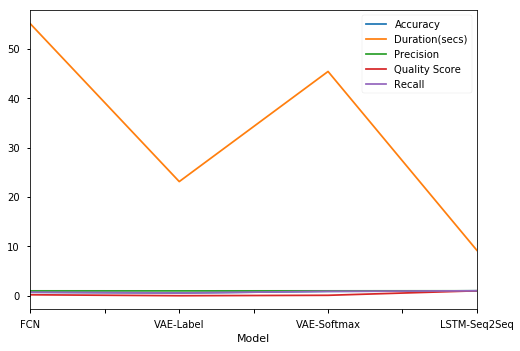

In [18]:
plot = all_scenarios_best.loc['Average Result'].drop('Number of Features', axis = 1).plot()
display_and_save("all_models_score_general_result", plot)

In [19]:
all_scenarios_best.loc['Worst Result']

,Accuracy,Duration(secs),Number of Features,Precision,Quality Score,Recall
Model,,,,,,
FCN,0.6815,55.0450,1,0.9922,0.0246,0.6838
VAE-Label,0.9834,30.7384,1,0.9834,0.0000,1.0000
VAE-Softmax,0.9723,53.2145,42,0.9867,0.0020,0.9851
LSTM-Seq2Seq,1.0000,9.2020,1,1.0000,1.0000,1.0000


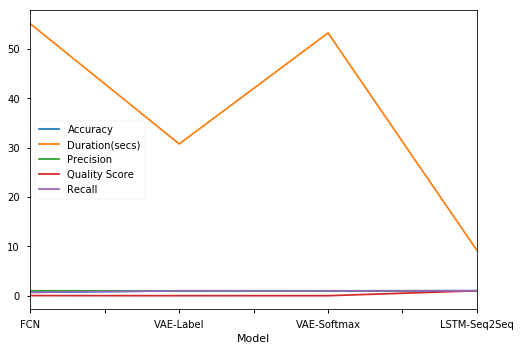

In [20]:
plot = all_scenarios_best.loc['Worst Result'].drop('Number of Features', axis = 1).plot()
display_and_save("all_models_score_worst_result", plot)

In [21]:
all_scenarios

,Accuracy,Duration(secs),Model,Number of Features,Precision,Quality Score,Recall,Scenarios
1,0.8424,55.0450,FCN,1,0.9973,0.5448,0.8284,Best Result
1,0.7098,55.0450,FCN,1,0.9899,0.1945,0.7069,Average Result
1,0.6815,55.0450,FCN,1,0.9922,0.0246,0.6838,Worst Result
1,0.7419,27.1311,VAE-Label,1,0.9752,0.0564,0.7530,Best Result
1,0.5578,23.1175,VAE-Label,8,0.9835,0.0057,0.5595,Average Result
1,0.9834,30.7384,VAE-Label,1,0.9834,0.0000,1.0000,Worst Result
1,0.7574,45.4121,VAE-Softmax,4,0.7600,0.3779,0.9468,Best Result
1,0.8853,45.4121,VAE-Softmax,4,0.9891,0.0904,0.8934,Average Result
1,0.9723,53.2145,VAE-Softmax,42,0.9867,0.0020,0.9851,Worst Result
1,1.0000,9.2020,LSTM-Seq2Seq,1,1.0000,1.0000,1.0000,Best Result


In [22]:
all_scenarios_display = all_scenarios.loc[:,[ 'Scenarios', 'Quality Score', 'Model']]
all_scenarios_pivot = all_scenarios_display.pivot_table('Quality Score', 'Model', 'Scenarios')
all_scenarios_pivot

Scenarios,Average Result,Best Result,Worst Result
Model,,,
FCN,0.1945,0.5448,0.0246
LSTM-Seq2Seq,1.0000,1.0000,1.0000
VAE-Label,0.0057,0.0564,0.0000
VAE-Softmax,0.0904,0.3779,0.0020


In [23]:
cmap = cm.get_cmap('Blues')
matplotlib.style.use('ggplot')
#print(plt.style.available)
matplotlib.rcParams['font.family'] = "Times New Roman"
#matplotlib.rcParams['axes.titlesize'] = 15


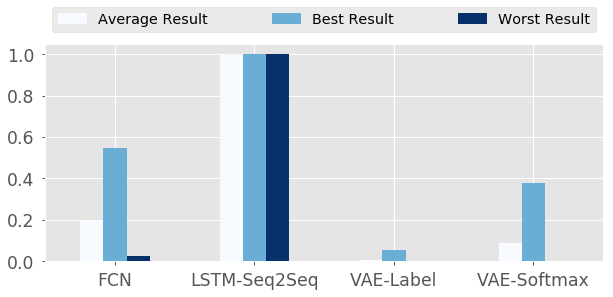

In [24]:
#matplotlib.style.use('fivethirtyeight')
#print(plt.style.available)
#plot_bar = all_scenarios_pivot.plot(kind='bar', figsize=[10,4], style='seaborn-colorblind', colormap=plt.cmaps.Qualitative)
#plot_bar.set_ylabel("Quality Score")
#display_and_save("All Results with Models in X Axis",plot_bar)
ax = all_scenarios_pivot.plot(kind='bar', rot=0,  legend=False, figsize=[10,4], cmap=cmap, title=False, fontsize='xx-large') 
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", ncol=3, fontsize='x-large')
ax.set_xlabel("")
display_and_save("All Results with Models in X Axis",ax)

In [25]:
all_scenarios_display = all_scenarios.loc[:,[ 'Scenarios', 'Quality Score', 'Model']]
all_scenarios_pivot = all_scenarios_display.pivot_table('Quality Score', 'Scenarios', 'Model' )
all_scenarios_pivot

Model,FCN,LSTM-Seq2Seq,VAE-Label,VAE-Softmax
Scenarios,,,,
Average Result,0.1945,1.0,0.0057,0.0904
Best Result,0.5448,1.0,0.0564,0.3779
Worst Result,0.0246,1.0,0.0000,0.0020


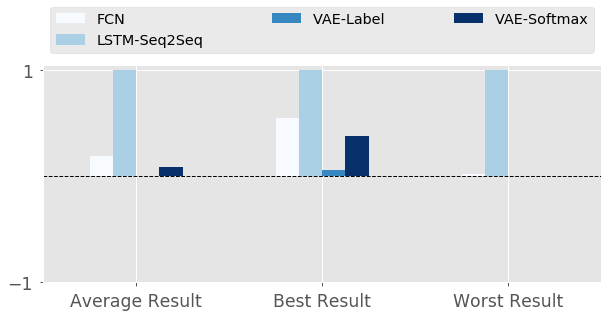

In [26]:
plot_bar = all_scenarios_pivot.plot(kind='bar', rot=0,  legend=False, figsize=[10,4], cmap=cmap, title=False, fontsize='xx-large')
#plot_bar.set_ylabel("Quality Score")
plot_bar.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", ncol=3, fontsize='x-large')
plot_bar.set_xlabel("")
plot_bar.set_yticks([-1,1])
plot_bar.axhline(ls='dashed', color = 'black', linewidth=1)
display_and_save("All Results with Scenarios in X Axis",plot_bar)

In [27]:
all_scenarios_display = all_scenarios.loc[:,[ 'Scenarios', 'Duration(secs)', 'Model']]
all_scenarios_pivot = all_scenarios_display.pivot_table('Duration(secs)', 'Scenarios', 'Model' )
all_scenarios_pivot

Model,FCN,LSTM-Seq2Seq,VAE-Label,VAE-Softmax
Scenarios,,,,
Average Result,55.045,9.202,23.1175,45.4121
Best Result,55.045,9.202,27.1311,45.4121
Worst Result,55.045,9.202,30.7384,53.2145


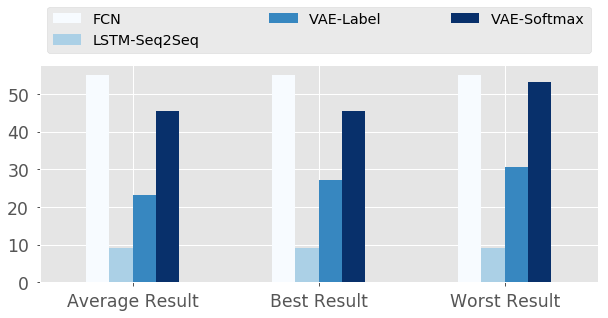

In [28]:
ax = all_scenarios_pivot.plot(kind='bar', rot=0,  legend=False, figsize=[10,4], cmap=cmap, title=False, fontsize='xx-large') 
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", ncol=3, fontsize='x-large')
ax.set_xlabel("")
display_and_save("All Duration(secs) with Scenarios in X Axis",plot_bar)

In [29]:
%%bash
zip -r result_plots.zip result_plots

updating: result_plots/ (stored 0%)
updating: result_plots/Results for LSTM Seq2Seq General case.png (deflated 25%)
updating: result_plots/all_models_score_general_result.png (deflated 27%)
updating: result_plots/all_models_score_best_result.png (deflated 26%)
updating: result_plots/all_models_score_worst_result.png (deflated 27%)
updating: result_plots/Results for VAE-LabelGeneration Worst case.png (deflated 17%)
updating: result_plots/Results for LSTM Seq2Seq Best case.png (deflated 24%)
updating: result_plots/Results for VAE-LabelGeneration General case.png (deflated 18%)
updating: result_plots/Results for VAE-Softmax General case.png (deflated 18%)
updating: result_plots/Results for Fully Connected General case.png (deflated 21%)
updating: result_plots/Results for LSTM Seq2Seq Worst case.png (deflated 26%)
updating: result_plots/Results for VAE-Softmax Worst case.png (deflated 22%)
updating: result_plots/Results for Fully Connected Worst case.png (deflated 21%)
updating: result_plo